<a href="https://colab.research.google.com/github/ipeirotis/sql_autograding/blob/main/Evaluation_8_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [69]:
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [70]:
import gcsfs

fs = gcsfs.GCSFileSystem(project="sql_autograding")
with fs.open("gs://sql_autograding/zero_shots_completion_800.csv") as f:
    data = pd.read_csv(f)

In [71]:
data = data.drop(columns='Unnamed: 0')
data.head()

,index,BSpace Course Name,BSpace Course Id,QuizName,﻿QuizId,QuizAttemptNumber,QuestionId,Question,QuestionType,InputUserAnswer,...,full_score,feedback,schema,0_mp,4_0_answer,4_0_grade,4_0_feedback,3_0_answer,3_0_grade,3_0_feedback
0,1838,"Databases for Business Analytics, MSQM SU23",277478,Assignment 3: Joins,301296,1,5119721,"List all the track names, the corresponding al...",Long Answer Question,"select t.track_name, a.artist_name, b.album_na...",...,1.0,NaN,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music dat...,Grade: 10/10\n\nFeedback: Great job! Your SQL ...,10.0,Great job! Your SQL query correctly retrieves ...,Grade: 8/10\n\nFeedback: \n- Your query correc...,8,"\n- Your query correctly joins the track, albu..."
1,5850,"Databases for Business Analytics, MSBA Jun'23",284280,Assignment 4: Aggregations,302626,1,5119732,"List the IDs of the albums, where the total al...",Long Answer Question,"SELECT artist_id, album_id, SUM(time) AS track...",...,1.0,NaN,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music dat...,Grade: 10/10\n\nFeedback: Great job! Your quer...,10.0,Great job! Your query correctly identifies the...,Grade: 7/10\n\nFeedback: \n- The student corre...,7,\n- The student correctly identified the table...
2,6124,"Databases for Business Analytics, TechMBA May'23",284275,Final Exam,302604,1,4969707,"From the Products table, we want to see the Pr...",Long Answer Question,"select ProductID, ProductName\r\nfrom Products...",...,5.0,NaN,"([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwi...,Grade: 10/10\n\nFeedback: Great job! Your SQL ...,10.0,Great job! Your SQL query is correct and it wi...,Grade: 9/10\n\nFeedback: \nGreat job! Your que...,9,\nGreat job! Your query is correct and retriev...
3,4928,"Databases for Business Analytics, MSBA Jun'23",284280,Assignment 2C: Filtering Queries,302620,1,5119676,"Find the tracks for the artist with id 3, from...",Long Answer Question,SELECT track_name\r\nFROM track\r\nWHERE artis...,...,1.0,NaN,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music dat...,Grade: 10/10\n\nFeedback: Great job! Your quer...,10.0,Great job! Your query correctly retrieves the ...,Grade: 8/10\n\nFeedback: \nThe student's answe...,8,\nThe student's answer is almost correct. They...
4,148,"Databases for Business Analytics, Winter 2023",251683,Final Exam,283453,1,4969706,"We would like to see just the FirstName, LastN...",Long Answer Question,"USE northwind;\r\nSELECT FirstName, LastName, ...",...,5.0,NaN,"([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwi...,Grade: 10/10\n\nFeedback: Great job! Your SQL ...,10.0,Great job! Your SQL query is correct and it me...,Grade: 9/10\n\nFeedback: \nGreat job on provid...,9,\nGreat job on providing the correct query to ...


In [72]:
data.columns

Index(['index', 'BSpace Course Name', 'BSpace Course Id', 'QuizName',
       '﻿QuizId', 'QuizAttemptNumber', 'QuestionId', 'Question',
       'QuestionType', 'InputUserAnswer', 'Score', 'NetId',
       'Comment left on User Response', 'AnswerKey', 'isQuery', 'Database',
       'full_score', 'feedback', 'schema', '0_mp', '4_0_answer', '4_0_grade',
       '4_0_feedback', '3_0_answer', '3_0_grade', '3_0_feedback'],
      dtype='object')

In [73]:
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

In [74]:
def parse4(text):
  grade = 0
  f = text.split('.')[0].split(' ')
  for i,w in enumerate(f):
    if w == "out" and i > 0:
      grade = f[i-1]
      break

  feedback = text.split('.')[1:]
  return grade, feedback

In [75]:
def parse3(text):
  grade_start = text.find("Grade: ") + len("Grade: ")
  grade_end = text.find("/", grade_start)
  grade = text[grade_start:grade_end]

  feedback_start = text.find("Feedback: ") + len("Feedback: ")
  feedback = text[feedback_start:]
  return grade, feedback


In [76]:
for i,r in data.iterrows():
  if is_float(r['4_0_grade'])==False:
    g,f = parse4(r['4_0_answer'])
    data.at[i,'4_0_grade'] = g
    data.at[i,'4_0_feedback'] = f
  elif is_float(r['3_0_grade'])==False:
    g,f = parse3(r['3_0_answer'])
    data.at[i,'3_0_grade'] = g
    data.at[i,'3_0_feedback'] = f

In [77]:
data['3_0_grade'].value_counts()

8     444
9     209
7     119
6      18
5       5
4       2
10      2
2       1
Name: 3_0_grade, dtype: int64

In [78]:
data['4_0_grade'].value_counts()

10.0    436
9.0     182
8.0      85
0.0      22
7.0      22
6.0      22
4.0      10
5.0       8
3.0       7
2.0       1
Name: 4_0_grade, dtype: int64

In [79]:
data.at[26, '4_0_grade'] = 8
data.at[179, '4_0_grade'] = 8
data.at[502, '4_0_grade'] = 9
data.at[703, '4_0_grade'] = 8
data.at[705, '4_0_grade'] = 8

## Evaluation begins (800 zero-shot rows)

In [80]:
df = data[['QuizName', 'QuestionId', 'Database', 'full_score', 'Score', '4_0_grade', '3_0_grade']]
df.head()

,QuizName,QuestionId,Database,full_score,Score,4_0_grade,3_0_grade
0,Assignment 3: Joins,5119721,music,1.0,1.0,10.0,8
1,Assignment 4: Aggregations,5119732,music,1.0,1.0,10.0,7
2,Final Exam,4969707,"['northwind', 'flights']",5.0,5.0,10.0,9
3,Assignment 2C: Filtering Queries,5119676,music,1.0,1.0,10.0,8
4,Final Exam,4969706,"['northwind', 'flights']",5.0,5.0,10.0,9


In [81]:
# scale gpt score
df['4_0_grade'] = (df['4_0_grade'].astype(float))*(df['full_score'].astype(float))/10
df['3_0_grade'] = (df['3_0_grade'].astype(float))*(df['full_score'].astype(float))/10
df.head()

<ipython-input-81-ca598a37f36c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['4_0_grade'] = (df['4_0_grade'].astype(float))*(df['full_score'].astype(float))/10
<ipython-input-81-ca598a37f36c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['3_0_grade'] = (df['3_0_grade'].astype(float))*(df['full_score'].astype(float))/10


,QuizName,QuestionId,Database,full_score,Score,4_0_grade,3_0_grade
0,Assignment 3: Joins,5119721,music,1.0,1.0,1.0,0.8
1,Assignment 4: Aggregations,5119732,music,1.0,1.0,1.0,0.7
2,Final Exam,4969707,"['northwind', 'flights']",5.0,5.0,5.0,4.5
3,Assignment 2C: Filtering Queries,5119676,music,1.0,1.0,1.0,0.8
4,Final Exam,4969706,"['northwind', 'flights']",5.0,5.0,5.0,4.5


In [82]:
df['4_0_grade'].value_counts()

1.00     279
0.90     106
7.50      56
0.80      56
5.00      40
10.00     35
1.80      27
11.00     25
0.00      22
6.75      21
9.00      21
1.60      14
6.00      12
0.60      12
0.70      10
8.00       8
7.00       7
0.40       6
0.50       6
4.50       5
2.00       4
4.00       4
5.25       4
9.90       3
0.30       3
1.20       3
3.60       2
3.00       2
2.25       2
3.50       1
0.20       1
3.20       1
3.30       1
8.80       1
Name: 4_0_grade, dtype: int64

In [83]:
df['3_0_grade'].value_counts()

0.80    301
0.90    128
0.70     59
6.00     48
8.00     41
6.75     31
4.50     27
1.60     25
1.40     20
7.00     18
4.00     17
8.80     16
5.25     16
9.00     14
9.90     11
0.60      8
7.70      3
3.50      3
1.00      3
3.20      3
0.50      2
2.00      2
3.75      2
6.60      1
1.20      1
Name: 3_0_grade, dtype: int64

In [84]:
df['full_score'].value_counts()

1.0     500
7.5      93
10.0     81
2.0      47
5.0      45
11.0     31
4.0       3
Name: full_score, dtype: int64

In [85]:
# who is the exact grade? - autograde
df['4_0_error'] = ((df['Score'] - df['4_0_grade']).abs() / (df['Score']+df['4_0_grade'])/2)
df['3_0_error'] = ((df['Score'] - df['3_0_grade']).abs() / (df['Score']+df['3_0_grade'])/2)
# .map('{:.2%}'.format)
df.head()

<ipython-input-85-30a1c63a282f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['4_0_error'] = ((df['Score'] - df['4_0_grade']).abs() / (df['Score']+df['4_0_grade'])/2)
<ipython-input-85-30a1c63a282f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['3_0_error'] = ((df['Score'] - df['3_0_grade']).abs() / (df['Score']+df['3_0_grade'])/2)


,QuizName,QuestionId,Database,full_score,Score,4_0_grade,3_0_grade,4_0_error,3_0_error
0,Assignment 3: Joins,5119721,music,1.0,1.0,1.0,0.8,0.0,0.055556
1,Assignment 4: Aggregations,5119732,music,1.0,1.0,1.0,0.7,0.0,0.088235
2,Final Exam,4969707,"['northwind', 'flights']",5.0,5.0,5.0,4.5,0.0,0.026316
3,Assignment 2C: Filtering Queries,5119676,music,1.0,1.0,1.0,0.8,0.0,0.055556
4,Final Exam,4969706,"['northwind', 'flights']",5.0,5.0,5.0,4.5,0.0,0.026316


In [86]:
df[['4_0_error', '3_0_error']].describe()

,4_0_error,3_0_error
count,800.000000,800.000000
mean,0.058101,0.066261
std,0.112229,0.073837
min,0.000000,0.000000
25%,0.000000,0.026316
50%,0.026316,0.055556
75%,0.055556,0.055556
max,0.500000,0.429577


In [87]:
dbs = df['Database'].unique()
error_lst_4 = []
error_lst_3 = []
for db in dbs:
  temp = df[df['Database']==db]
  error_lst_4.append(temp['4_0_error'].mean())
  error_lst_3.append(temp['3_0_error'].mean())
print(error_lst_4)

[0.06564518318635328, 0.0358271873753566, 0.08017097821830242, 0.021094402673350034]


In [88]:
print(error_lst_3)

[0.06943220106412977, 0.05461585663693884, 0.0811055361086915, 0.055801267875571284]


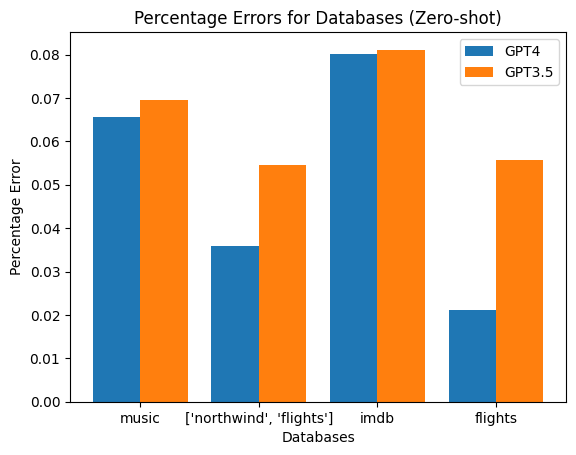

In [89]:
X_axis = np.arange(len(dbs))

plt.bar(X_axis - 0.2, error_lst_4, 0.4, label = 'GPT4')
plt.bar(X_axis + 0.2, error_lst_3, 0.4, label = 'GPT3.5')

plt.xticks(X_axis, dbs)
plt.xlabel("Databases")
plt.ylabel("Percentage Error")
plt.title("Percentage Errors for Databases (Zero-shot)")
plt.legend()
plt.show()

- Errors for GPT 4 and 3.5 are really similar for each database but errors for GPT 4 is slightly lower
- flights has the lowest average errors

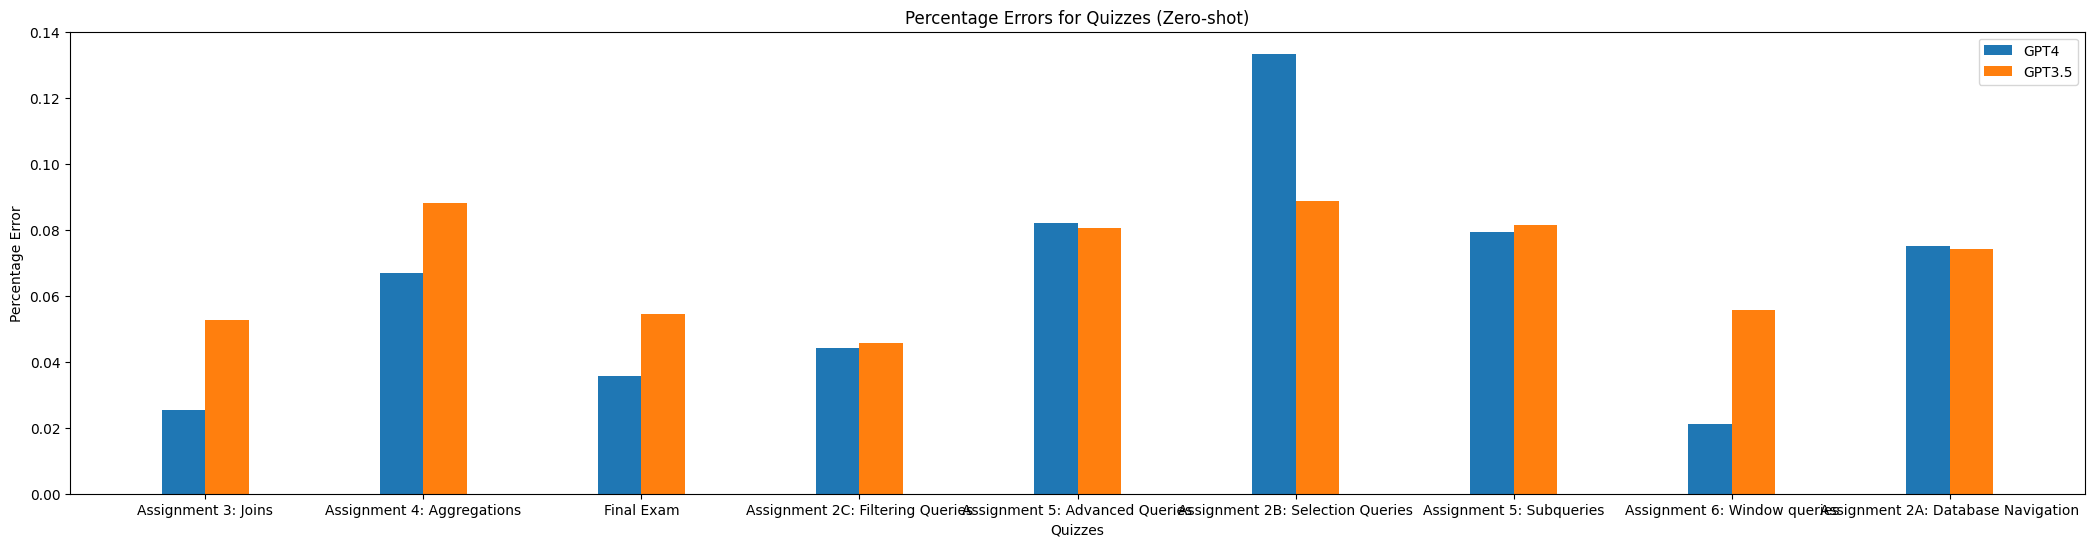

In [90]:
qs = df['QuizName'].unique()
error_lst_4 = []
error_lst_3 = []
for q in qs:
  temp = df[df['QuizName']==q]
  error_lst_4.append(temp['4_0_error'].mean())
  error_lst_3.append(temp['3_0_error'].mean())

X_axis = np.arange(len(qs))

plt.figure(figsize=(26,6))
plt.bar(X_axis - 0.1, error_lst_4, 0.2, label = 'GPT4')
plt.bar(X_axis + 0.1, error_lst_3, 0.2, label = 'GPT3.5')

plt.xticks(X_axis, qs)
plt.xlabel("Quizzes")
plt.ylabel("Percentage Error")
plt.title("Percentage Errors for Quizzes (Zero-shot)")
plt.legend()
plt.show()

- GPT 4 errors are generally lower than GPT 3 errors across quizzes
- Assignment 6 has the lowest average percentage errors

## Jointplots
https://seaborn.pydata.org/generated/seaborn.jointplot.html

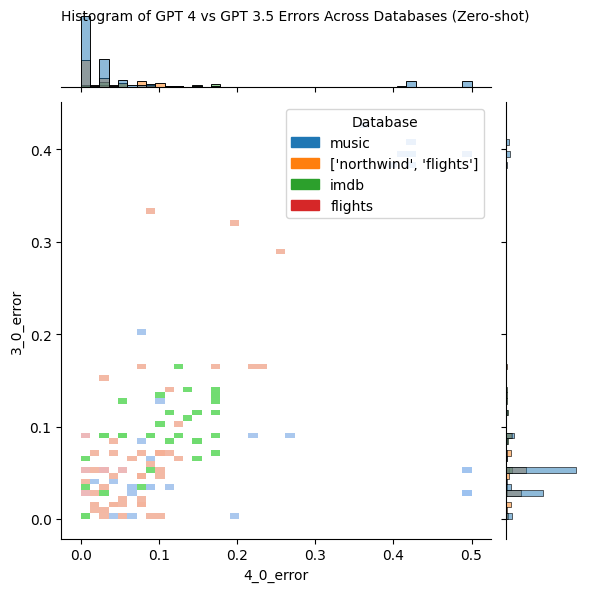

In [91]:
j = sns.jointplot(data=df, x="4_0_error", y="3_0_error", hue="Database", kind='hist')
j.fig.suptitle("Histogram of GPT 4 vs GPT 3.5 Errors Across Databases (Zero-shot)", fontsize=10)
plt.show()

- Hist easier to interpret
- The hardest database to grade is music for both GPT models. (maximum value)
- Northwind and flights is harder to grade for GPT 3.5.
- Most errors aggregated below 0.2, with imdb and flights aggregated

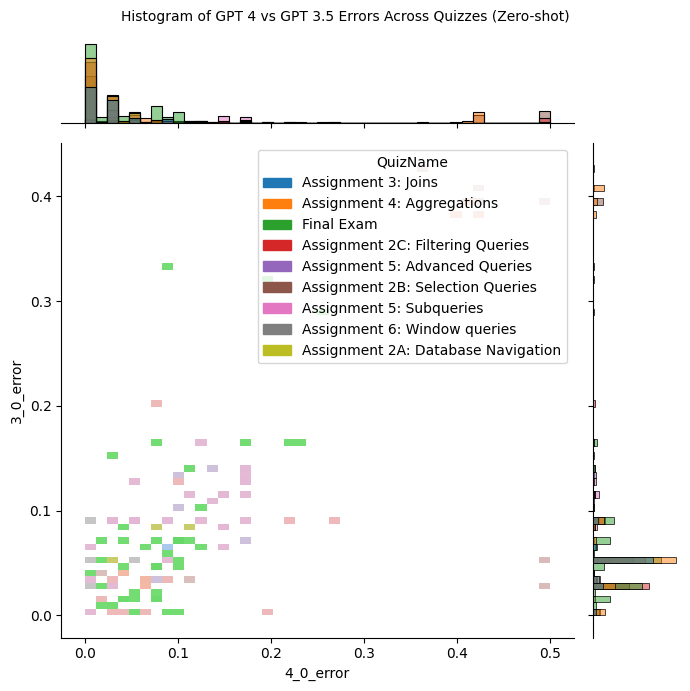

In [92]:
g = sns.jointplot(data=df, x="4_0_error", y="3_0_error", hue="QuizName", kind='hist', height=7)
g.fig.suptitle("Histogram of GPT 4 vs GPT 3.5 Errors Across Quizzes (Zero-shot)", fontsize=10)
plt.tight_layout()
plt.show()

- Further decompose each database to quizzes
- Also comes to Assignment 2C and 4 being the hardest one
- Some errors for Final and 2C.
- Other quizzes spread out from 0 to 0.18

#### Lots of grades near 0 because there are 500 questions with full_score=1

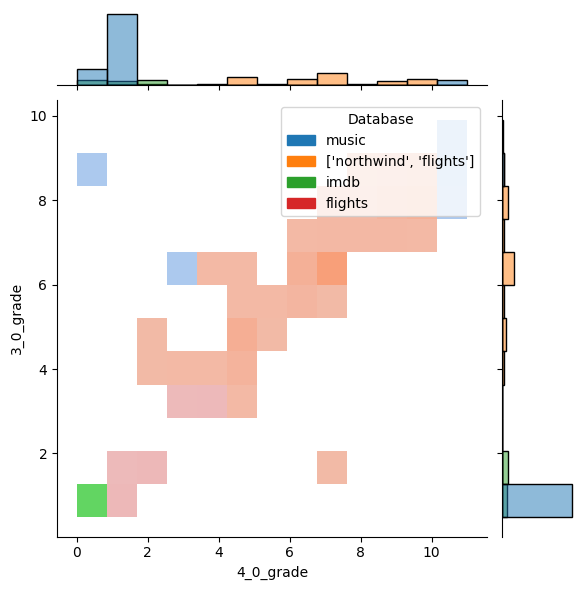

In [93]:
sns.jointplot(data=df, x="4_0_grade", y="3_0_grade", hue='Database', kind='hist')

## Few-shot Evaluation

In [41]:
fs = gcsfs.GCSFileSystem(project="sql_autograding")
with fs.open("gs://sql_autograding/few_completions.csv") as f:
    data = pd.read_csv(f)

In [42]:
data = data.drop(columns='Unnamed: 0')
data.head()

,index,BSpace Course Name,BSpace Course Id,QuizName,﻿QuizId,QuizAttemptNumber,QuestionId,Question,QuestionType,InputUserAnswer,...,schema,4_few_mp,num,4_answer,4_grade,4_feedback,3_few_mp,3_answer,3_grade,3_feedback
0,1838,"Databases for Business Analytics, MSQM SU23",277478,Assignment 3: Joins,301296,1,5119721,"List all the track names, the corresponding al...",Long Answer Question,"select t.track_name, a.artist_name, b.album_na...",...,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2496,"{""grade"": ""10/10"", ""feedback"": ""Your answer is...",10/10,Your answer is correct. You have successfully ...,\n a. We are working with the music datab...,"{""grade"": ""1.0"", ""feedback"": ""The query provid...",1.0,The query provided by the student is correct a...
1,5850,"Databases for Business Analytics, MSBA Jun'23",284280,Assignment 4: Aggregations,302626,1,5119732,"List the IDs of the albums, where the total al...",Long Answer Question,"SELECT artist_id, album_id, SUM(time) AS track...",...,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2529,"{""grade"": ""10/10"", ""feedback"": ""Your answer is...",10/10,Your answer is correct. You have successfully ...,\n a. We are working with the music datab...,"{""grade"": ""0.7"", ""feedback"": ""The query is mis...",0.7,The query is missing one of the album keys in ...
2,6124,"Databases for Business Analytics, TechMBA May'23",284275,Final Exam,302604,1,4969707,"From the Products table, we want to see the Pr...",Long Answer Question,"select ProductID, ProductName\r\nfrom Products...",...,"([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwind...,2468,"{""grade"": ""10"", ""feedback"": ""Your answer is co...",10,Your answer is correct. Good job on using the ...,\n a. We are working with the ['northwind...,"{""grade"": ""5.0"", ""feedback"": ""Your query is co...",5.0,Your query is correct and returns the desired ...
3,4928,"Databases for Business Analytics, MSBA Jun'23",284280,Assignment 2C: Filtering Queries,302620,1,5119676,"Find the tracks for the artist with id 3, from...",Long Answer Question,SELECT track_name\r\nFROM track\r\nWHERE artis...,...,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2435,"{""grade"": ""10/10"", ""feedback"": ""Your answer is...",10/10,Your answer is correct. You have successfully ...,\n a. We are working with the music datab...,"{""grade"": ""10"", ""feedback"": ""The student's ans...",10,The student's answer is correct. They correctl...
4,148,"Databases for Business Analytics, Winter 2023",251683,Final Exam,283453,1,4969706,"We would like to see just the FirstName, LastN...",Long Answer Question,"USE northwind;\r\nSELECT FirstName, LastName, ...",...,"([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwind...,2386,"{""grade"": ""10/10"", ""feedback"": ""Great job! You...",10/10,Great job! Your SQL query is correct and it me...,\n a. We are working with the ['northwind...,"{""grade"": ""5.0"", ""feedback"": ""The query provid...",5.0,The query provided by the student is correct a...


In [46]:
def scale_score(gpt_score, full_score):
  if str(gpt_score).endswith("/10") or str(gpt_score).endswith("/10.0") or str(gpt_score).endswith("/2.0") or str(gpt_score).endswith("/11.0") or str(gpt_score).endswith("/1.0"):
    numerator, denominator = map(float, gpt_score.split('/'))
    g = float(numerator)/float(denominator)
    return g*full_score
  else:
    return (float(gpt_score)*full_score)/10

In [47]:
lst4 = []
lst3 = []
for i, r in data.iterrows():
  grade4 = scale_score(r['4_grade'], r['full_score'])
  grade3 = scale_score(r['3_grade'], r['full_score'])
  lst4.append(grade4)
  lst3.append(grade3)

data['4_grade_scaled'] = lst4
data['3_grade_scaled'] = lst3

In [50]:
data['4_error'] = ((data['Score'] - data['4_grade_scaled']).abs() / (data['Score']+data['4_grade_scaled'])/2)
data['3_error'] = ((data['Score'] - data['3_grade_scaled']).abs() / (data['Score']+data['3_grade_scaled'])/2)
# .map('{:.2%}'.format)
df.head()

,QuizName,QuestionId,Database,full_score,Score,4_0_grade,3_0_grade,4_0_error,3_0_error
0,Assignment 3: Joins,5119721,music,1.0,1.0,1.0,0.8,0.0,0.055556
1,Assignment 4: Aggregations,5119732,music,1.0,1.0,1.0,0.7,0.0,0.088235
2,Final Exam,4969707,"['northwind', 'flights']",5.0,5.0,5.0,4.5,0.0,0.026316
3,Assignment 2C: Filtering Queries,5119676,music,1.0,1.0,1.0,0.8,0.0,0.055556
4,Final Exam,4969706,"['northwind', 'flights']",5.0,5.0,5.0,4.5,0.0,0.026316


In [51]:
data[['4_error', '3_error']].describe()

,4_error,3_error
count,300.000000,300.000000
mean,0.044741,0.172125
std,0.108219,0.184029
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.071429
75%,0.026316,0.409091
max,0.500000,0.461538


### Errors among Databases

[0.05030857021962997, 0.03141352394733159, 0.0614706196943039, 0.0]


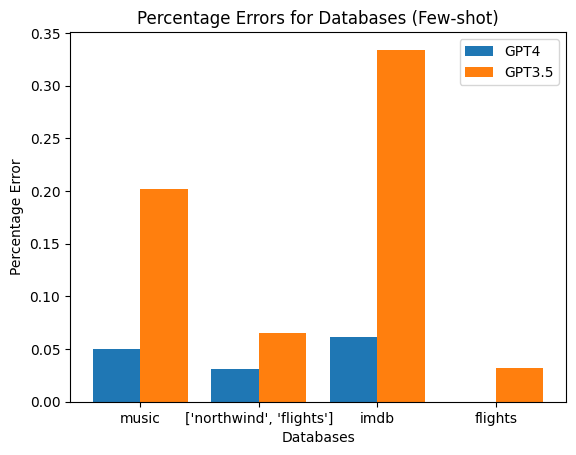

In [57]:
dbs = data['Database'].unique()
error_lst_4 = []
error_lst_3 = []
for db in dbs:
  temp = data[data['Database']==db]
  error_lst_4.append(temp['4_error'].mean())
  error_lst_3.append(temp['3_error'].mean())
print(error_lst_4)

X_axis = np.arange(len(dbs))

plt.bar(X_axis - 0.2, error_lst_4, 0.4, label = 'GPT4')
plt.bar(X_axis + 0.2, error_lst_3, 0.4, label = 'GPT3.5')

plt.xticks(X_axis, dbs)
plt.xlabel("Databases")
plt.ylabel("Percentage Error")
plt.title("Percentage Errors for Databases (Few-shot)")
plt.legend()
plt.show()

- Flights also has a lowest average percentage error among databases
- GPT 4 has far smaller errors than GPT 3

### Errors among Quizzes

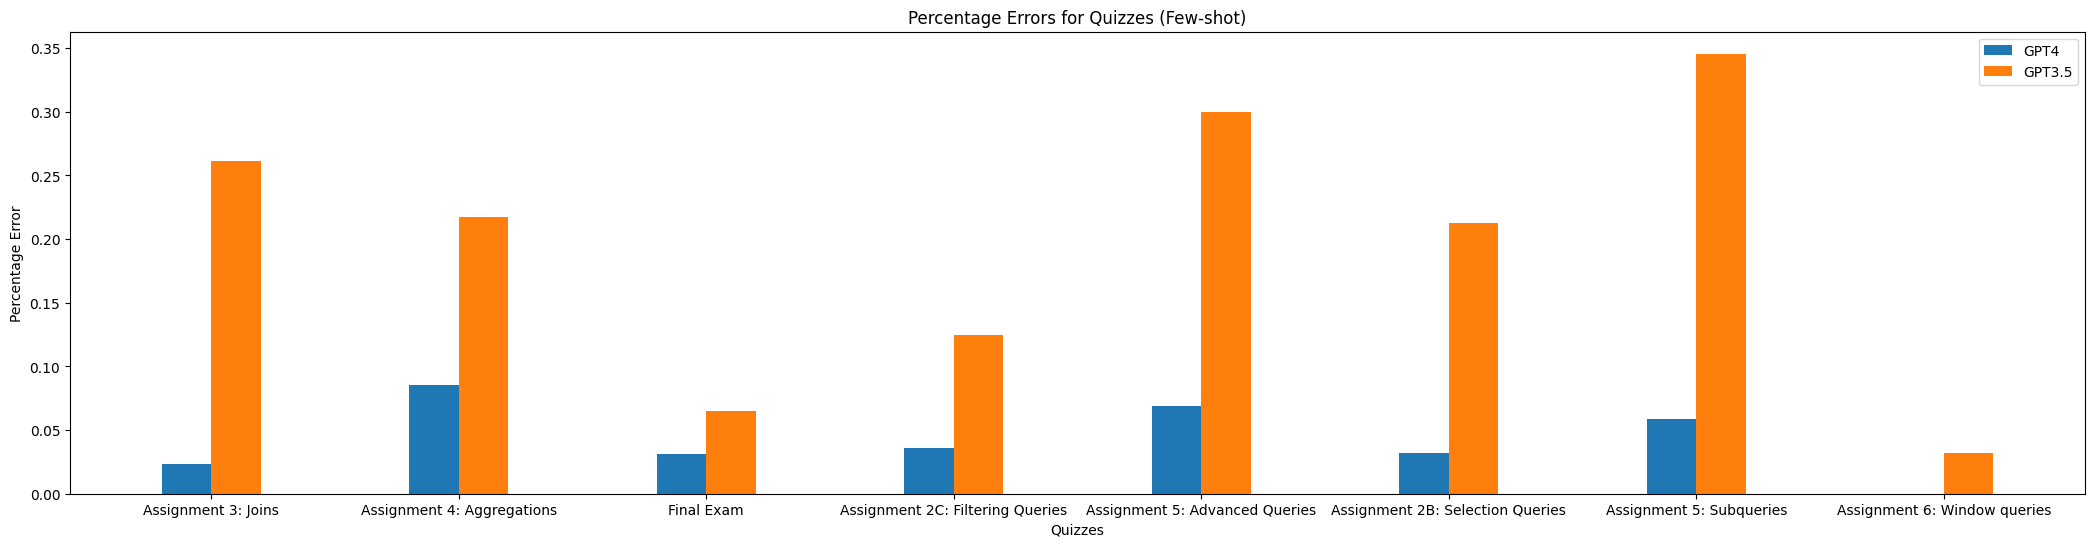

In [58]:
qs = data['QuizName'].unique()
error_lst_4 = []
error_lst_3 = []
for q in qs:
  temp = data[data['QuizName']==q]
  error_lst_4.append(temp['4_error'].mean())
  error_lst_3.append(temp['3_error'].mean())

X_axis = np.arange(len(qs))

plt.figure(figsize=(26,6))
plt.bar(X_axis - 0.1, error_lst_4, 0.2, label = 'GPT4')
plt.bar(X_axis + 0.1, error_lst_3, 0.2, label = 'GPT3.5')

plt.xticks(X_axis, qs)
plt.xlabel("Quizzes")
plt.ylabel("Percentage Error")
plt.title("Percentage Errors for Quizzes (Few-shot)")
plt.legend()
plt.show()

- Assignment 6 has a smallest average error across quizzes
- GPT 4 has far smaller errors than GPT 3


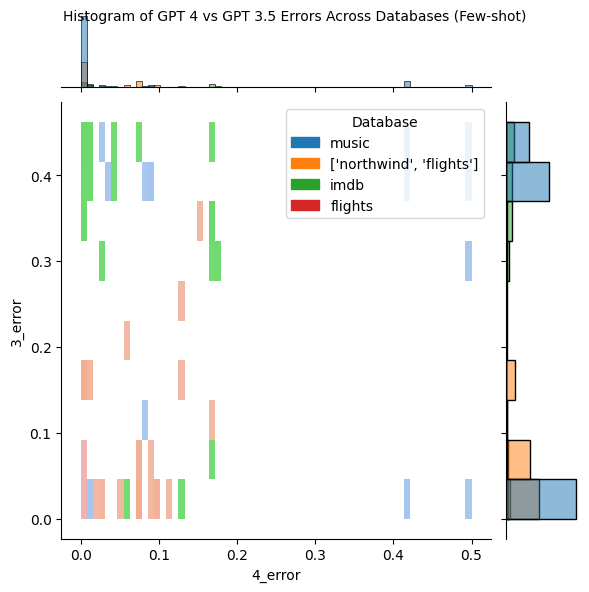

In [66]:
j = sns.jointplot(data=data, x="4_error", y="3_error", hue="Database", kind='hist')
j.fig.suptitle("Histogram of GPT 4 vs GPT 3.5 Errors Across Databases (Few-shot)", fontsize=10)
plt.show()

- Music has the maximum errors, dispersed loosely from 0 to 0.5
- IMDB are harder to grade for GPT 3.5

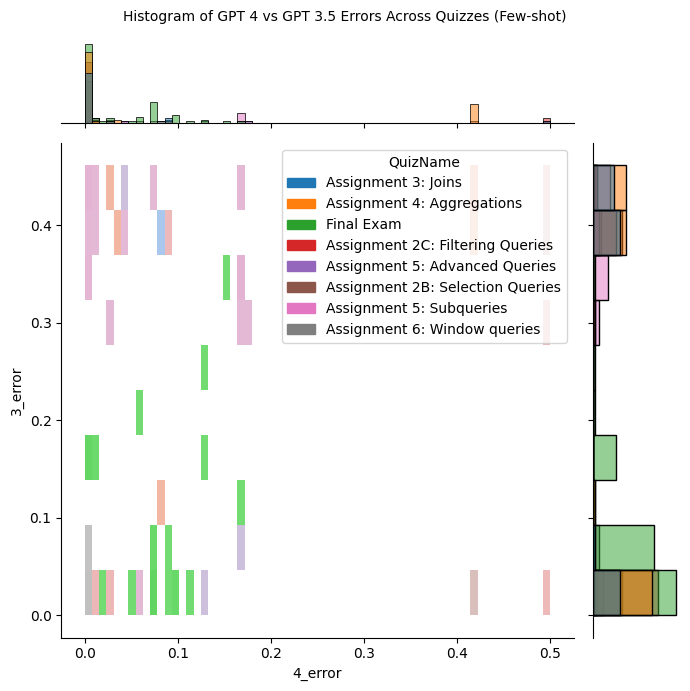

In [67]:
g = sns.jointplot(data=data, x="4_error", y="3_error", hue="QuizName", kind='hist', height=7)
g.fig.suptitle("Histogram of GPT 4 vs GPT 3.5 Errors Across Quizzes (Few-shot)", fontsize=10)
plt.tight_layout()
plt.show()

- Assignment 2C and 4 have the maximum errors
- Assignment 5 is harder to grade for GPT 3.5